## Investigation of energy fluctuations

In this notebook we will use the `rumd.post_analysis` toolbox to investiage potential energy fluctuations in a simulation of the Lennard-Jones model. 


### Run example simulation

First conduct a simlation of the Lennard-Jones model truncated at $r_c=2.5\sigma$ at temperature $T=1.0{\varepsilon/k_B}$ and density $\rho_l=0.9233\sigma^{-3}$ (the freezing density). For this simulation we print thermodynamic information every time-step, however, we do not need positional information.


In [1]:
# create initial configuration
!rumd_init_conf --cells=10 --rho=0.9233

rumd_init_conf: Use  -h or --help for more information.
Lattice type:                 sc
Number of lattice sites:      1000
Total number of particles:    1000
Number of types:              1
Number of particles of types: 1000
Mass of types:                1
Lengths of box vectors:       10.2696 10.2696 10.2696
Box volume:                   1083.07
Number density:               0.9233
Write configuration to start.xyz.gz with temperature 1


In [2]:
# import RUMD
import rumd
from rumd.Simulation import Simulation
import os.path

CUDA: node=nsm-i310 device=0 name="GeForce GT 1030"


In [3]:
%%time
# Run simulation if TrajectoryFiles does not exist
if not os.path.isdir('TrajectoryFiles'):
    # create simulation object
    sim = Simulation("start.xyz.gz")

    # create integrator object
    itg = rumd.IntegratorNVT(targetTemperature=1.0, timeStep=0.005)
    sim.SetIntegrator(itg)

    # create potential object
    pot = rumd.Pot_LJ_12_6(cutoff_method = rumd.ShiftedPotential)
    pot.SetParams(i=0, j=0, Epsilon=1.0, Sigma=1.0, Rcut=2.5)
    sim.SetPotential(pot)

    # set output
    sim.SetOutputScheduling('trajectory', 'none')
    sim.SetOutputScheduling('energies', 'linear', interval=1)

    # run simulation
    steps = int(2**20)
    numberOfBlocks = 8
    blockSize = int(steps/numberOfBlocks)
    sim.SetBlockSize(blockSize)
    print('Equilibration run\n')
    sim.Run(steps, suppressAllOutput=True)
    print('Production run')
    sim.Run(steps)
    sim.sample.TerminateOutputManagers()


Setting number of particles and allocating on host and device:
Number of particles (N):      1000
Particles per block (pb):     32
Threads per particle (tp):    4
Number of blocks:             32
Virtual particles:            1024
Unused virtual particles:     24
Threads per block:            128
Number of threads:            4096

Updated to 2997 degrees of freedom.
Equilibration run
potLJ_12_6: Sigma = 1, Epsilon = 1, Rcut = 2.5.

potLJ_12_6: A12 = 4, A6 = -4, Rcut = 2.5.
Production run
Output blockSize=131072, numBlocks=9
Size of the last incomplete block 0
Creating directory ./TrajectoryFiles
Finished writing restart nr.    0
Finished writing energies nr.    0
CPU times: user 4min 25s, sys: 12.1 s, total: 4min 37s
Wall time: 4min 38s


In [4]:
!du -sh

20M	.


### Load potential energies
First we import the post analysis (`pa`) toolbox and load thermodynamic information as a Pandas Dataframe (`df`).

In [5]:
# Import the post analysis toolbox
import sys
sys.path.append('/net/debye/urp/rumd/Python/rumd')  # HEADS-UP: Change to your latest version of RUMD.
import post_analysis as pa

In [6]:
df = pa.get_energies_as_DataFrame()
df

,t,ke,pe,p,T,Etot,W
0,0.000,1.41912,-5.14222,5.09713,0.947026,-3.72310,4.57353
1,0.005,1.41648,-5.14020,5.11310,0.945268,-3.72372,4.59258
2,0.010,1.42103,-5.14159,5.11737,0.948303,-3.72056,4.59417
3,0.015,1.43160,-5.14537,5.11377,0.955357,-3.71377,4.58323
4,0.020,1.44657,-5.15031,5.10718,0.965345,-3.70374,4.56609
...,...,...,...,...,...,...,...
1048571,5242.855,1.48909,-5.25290,4.61085,0.993722,-3.76381,4.00016
1048572,5242.860,1.49943,-5.24770,4.63682,1.000620,-3.74827,4.02138
1048573,5242.865,1.50774,-5.24041,4.67091,1.006170,-3.73266,4.05277
1048574,5242.870,1.51455,-5.23205,4.70944,1.010710,-3.71750,4.08995


We plot the potential energy fluctuation as a function of time, $u(t)$.

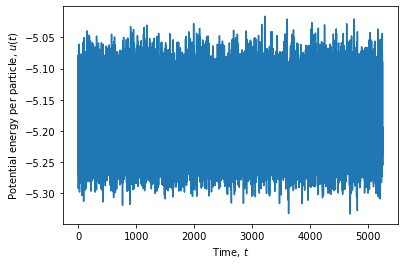

In [7]:
import matplotlib.pyplot as plt
%notebook inline

plt.figure()
plt.plot(df.t, df.pe)
plt.xlabel(r'Time, $t$')
plt.ylabel(r'Potential energy per particle, $u(t)$')
plt.show()

Standard properties can be computed using the build-in Pandas methods.

In [8]:
df['pe'].describe()

count    1.048576e+06
mean    -5.177708e+00
std      3.545046e-02
min     -5.333030e+00
25%     -5.201740e+00
50%     -5.177880e+00
75%     -5.153920e+00
max     -5.016000e+00
Name: pe, dtype: float64

### Compute auto-correlation function
The (time) auto-correlation function
$$
   C_{uu}(t) = \langle u(0)u(t) \rangle
$$
is computed with the `time_correlation(y)` function.

In [9]:
help(pa.time_correlation)

Help on function time_correlation in module post_analysis:

time_correlation(x, y=None)
    Compute the time correlation function 
    The time correlation function :math:`C(t)` is computed using
    the Wiener–Khinchin theorem with the FFT algorithm and zero padding.
    
     .. math::
    
         C(t) = \langle \Delta x(\tau) \Delta y(\tau + t) \rangle_\tau
    
         \Delta x(t) = x(t) - \langle x \rangle
    
         \Delta y(t) = x(y) - \langle y \rangle



In [10]:
pa.documentation_in_jupyter(pa.time_correlation)

In [11]:
%%time
y = df['pe']
C = pa.time_correlation(y)
C

CPU times: user 342 ms, sys: 35.3 ms, total: 377 ms
Wall time: 369 ms


array([ 1.25673402e-03,  1.24118872e-03,  1.19654224e-03, ...,
       -5.63391884e-09, -3.46749130e-09, -1.54064633e-09])

The first element (`uu[0]`) $\langle(\Delta u(0))^2\rangle$ is the variance of the potential energy (`df['pe'].var()`).

In [12]:
C[0]

0.0012567340169374014

In [13]:
df['pe'].var()

0.0012567352154535263

Here is a plot normalized to start at one.

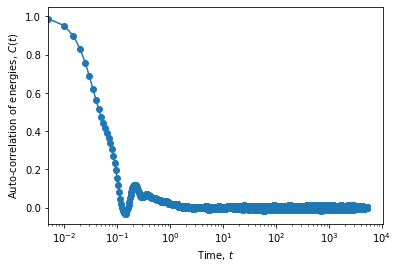

In [14]:
t = df['t']
plt.figure()
plt.plot(t, C/C[0], 'o-')
plt.xscale('log')
plt.ylabel(r'Auto-correlation of energies, $C(t)$')
plt.xlabel(r'Time, $t$')
plt.xlim(t[1], None)
plt.show()

When plotting $C(t)$, it can often be desirable to a bin data on a logrithmic scale to average out noise on long-time-scales.

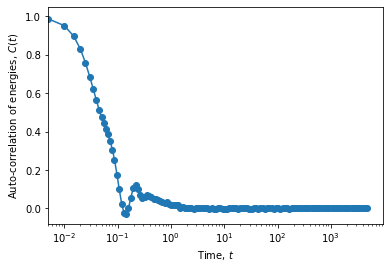

In [15]:
# Make logaritmic running averages
points_per_decade=24
t_avg = pa.run_avg_log(t, points_per_decade)
C_avg = pa.run_avg_log(C, points_per_decade)

# Plot logaritmic running averages
plt.figure()
plt.plot(t_avg, C_avg/C_avg[0], 'o-')
plt.xscale('log')
plt.ylabel(r'Auto-correlation of energies, $C(t)$')
plt.xlabel(r'Time, $t$')
plt.xlim(t[1], None)
plt.show()

### Frequency dependent response

Fluctuation-dispation (FD) theorem dictates that $C(t)$ computed from fluctuation (see above) correspond to what would be meassured in linear ageing experiment where the conjugated thermodynamic variable is changed abruptly at $t=0$. If the conjugated variable is changed sinosodial one would meassure the frequency dependent response function. We can compute this using the `frequency_dependent_response` function. As seen in the documentation (see below), $\mu(\omega)$ is computed using a Fourier-Laplace transform.

In [16]:
help(pa.frequency_dependent_response)

Help on function frequency_dependent_response in module post_analysis:

frequency_dependent_response(x, y=None, dt=1.0, prefactor=1.0)
    Frequency dependent responce
    The frequency dependent responce :math:`\mu(\omega)` is estimate from time-series
    assuming the fluctuation-dissipation theorem.
    
     .. math::
    
         \mu(\omega) = A\int_0^\infty \dot C(t)\exp(-i \omega t) dt
    
         \dot C(t) = \frac{d}{dt} \langle \Delta x(\tau) \Delta y(\tau + t) \rangle_\tau
    
         \Delta x(t) = x(t) - \langle x \rangle
    
         \Delta y(t) = y(t) - \langle y \rangle
    
    dt is the sample time of the time-series.
    Notice that the user must provide a prefactor
    to get the correct scaling responce function.
    The prefactor (:math:`A`) is -1/kT**2
    for the frequency dependent heat capacity.
    If y is None then it is set to be the same as the x time-series.
    The implimentation uses the FFT algorithm
    with zero-padding for Laplace transform,
   

In [17]:
pa.documentation_in_jupyter(pa.frequency_dependent_response)

In [18]:
%%time
dt = pa.get_energies_time_interval()
omega, mu = pa.frequency_dependent_response(y, dt=dt, prefactor=1.0)

CPU times: user 451 ms, sys: 52.3 ms, total: 503 ms
Wall time: 497 ms


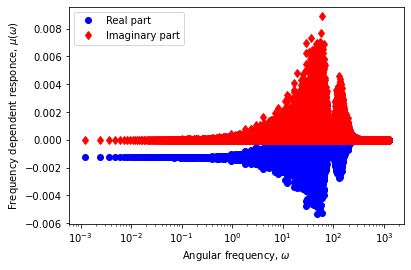

In [19]:
import numpy as np

plt.figure()
plt.plot(omega, np.real(mu), 'bo', label='Real part')
plt.plot(omega, np.imag(mu), 'rd', label='Imaginary part')
plt.xscale('log')
plt.ylabel(r'Frequency dependent responce, $\mu(\omega)$')
plt.xlabel(r'Angular frequency, $\omega$')
plt.legend()
plt.show()

Again, it can be advanges to use logaritmic averaging when plotting the information.

In [20]:
# Make logaritmic running averages
points_per_decade=24
omega_avg = pa.run_avg_log(omega, points_per_decade)
mu_avg = pa.run_avg_log(mu, points_per_decade)

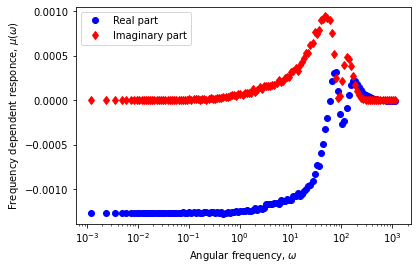

In [21]:
# Plot logaritmic running averages
plt.figure()
plt.plot(omega_avg, np.real(mu_avg), 'bo', label='Real part')
plt.plot(omega_avg, np.imag(mu_avg), 'rd', label='Imaginary part')
plt.xscale('log')
plt.ylabel(r'Frequency dependent responce, $\mu(\omega)$')
plt.xlabel(r'Angular frequency, $\omega$')
plt.legend()
plt.show()

### Clean-up

In [22]:
# Clean-up by deleting simulation files
clean_up_simulation_files = True
if clean_up_simulation_files:
    import shutil
    shutil.rmtree('./TrajectoryFiles', ignore_errors=False, onerror=None)

In [23]:
!du -sh

244K	.
